# Graph States generation and display

This notebook need the python modules qiskit, qutip and seaborn to be able to run. Simply run :

pip install qiskit qutip seaborn

## Some definitions and properties of graph states

Graph states are specific entangled states that are represented by a graph. They have interesting properties in many fields of quantum computing [[1]](#References), therefore they are points of interest.

##### Definition:

Two definitions of a graph state exist. Since they are equivalent, we will only consider the following:

Given a graph $G=(V,E)$, with the set of vertices $V$ and the set of edges $E$, the corresponding graph state is defined as:
<p style="text-align: center;">
$\left|G\right\rangle = \prod_{(a,b)\in E} CZ^{\{a,b\}} \left|+\right\rangle^{\otimes V}$
</p>

where $|+\rangle = \frac{|0\rangle + |1\rangle}{\sqrt2}$ and $CZ^{\{a,b\}}$  is the controlled-Z interaction between the two vertices (corresponding to two qubits) $a$ and $b$. The operators order in the product doesn't matter since CZ gates commute between themselves. We can write the CZ gate with the following matrix :
<p style="text-align: center;">
$CZ = \begin{bmatrix}
1 & 0 & 0 & 0 \\
0 & 1 & 0 & 0 \\
0 & 0 & 1 & 0 \\
0 & 0 & 0 & -1 \\
\end{bmatrix}$
</p>

<br/>

Therefore, we can write the action of a CZ gate as: $CZ^{\{1,2\}}|0\rangle_1 |\pm\rangle_2 = |0\rangle_1 |\pm\rangle_2$     and     $CZ^{\{1,2\}}|1\rangle_1 |\pm\rangle_2 = |1\rangle_1 |\mp\rangle_2$.

Let’s illustrate this with an example. The associated graph of: $|\Psi_{graph}\rangle = CZ^{\{0,1\}}\, CZ^{\{1,2\}}\, CZ^{\{0,2\}}\, CZ^{\{3,2\}}|+\rangle_0 |+\rangle_1 |+\rangle_2 |+\rangle_3$ is the following. The graph is generated as an output later in this notebook. We will now see several ways to create and display these states.

## Generating entangled states with a circuit

We will first use a 3-qubits circuit. We need to implement two CZ gates on it to generate the 3-qubits linear graph state.

These gates are post-selected CZ gates which have a probability of success of $\frac{1}{9}$.

In [2]:
import math
import perceval as pcvl
import networkx as nx
from perceval.utils import StateGenerator, Encoding
from qiskit.visualization import plot_state_qsphere
from qutip import plot_schmidt

### Implementation in Perceval

For this circuit, we use path encoded qubits with 3 photons as input.

In [3]:
# Modes number of the circuit
m = 10

In [4]:
def cz(i):
    """Return a post selected CZ gate labeled with i"""
    
    CZ = pcvl.Circuit(6, name="CZ" + str(i))
    CZ.add((0, 1), pcvl.BS(pcvl.BS.r_to_theta(1/3)))
    CZ.add((2, 3), pcvl.BS(pcvl.BS.r_to_theta(1/3)))
    CZ.add((4, 5), pcvl.BS(pcvl.BS.r_to_theta(1/3)))
    CZ.add(2, pcvl.PS(math.pi)) 
    
    return CZ   

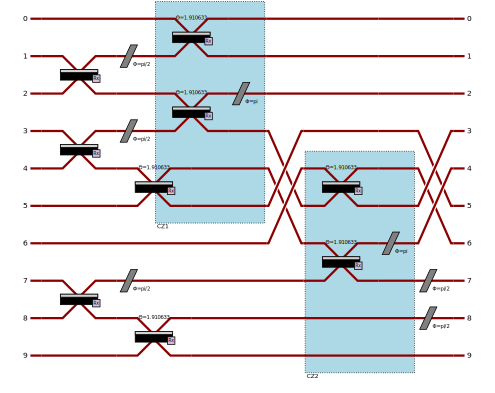

In [5]:
# Creation of the full circuit
c_graph_lin = pcvl.Circuit(10, name="C_Graph")\
    .add((1, 2), pcvl.BS()).add(1, pcvl.PS(math.pi/2))\
    .add((3, 4), pcvl.BS()).add(3, pcvl.PS(math.pi/2))\
    .add((7, 8), pcvl.BS()).add(7, pcvl.PS(math.pi/2))\
    .add(0, cz(1), merge=False)\
    .add((3,4,5,6), pcvl.PERM([2, 3, 0, 1]))\
    .add(4, cz(2), merge=False)\
    .add(8, pcvl.PS(math.pi/2)).add(7, pcvl.PS(math.pi/2))\
    .add((3,4,5,6), pcvl.PERM([2, 3, 0, 1]))

pcvl.pdisplay(c_graph_lin, recursive=True, render_size=0.6)

#### Logical states

Logical states are path encoded on the Fock States.

Due to post-selection, only few states of the full Fock space are relevant.

- Mode 0,5,6,9 are auxiliary.
- 1st qubit is path encoded in modes 1 & 2
- 2nd qubit in 3 & 4
- 3rd qubit in 7 & 8

In [6]:
# Basis for three qubits
states = [
    pcvl.BasicState([0,1,0,1,0,0,0,1,0,0]),  #|000>
    pcvl.BasicState([0,1,0,1,0,0,0,0,1,0]),  #|001>
    pcvl.BasicState([0,1,0,0,1,0,0,1,0,0]),  #|010>
    pcvl.BasicState([0,1,0,0,1,0,0,0,1,0]),  #|011>
    pcvl.BasicState([0,0,1,1,0,0,0,1,0,0]),  #|100>
    pcvl.BasicState([0,0,1,1,0,0,0,0,1,0]),  #|101>
    pcvl.BasicState([0,0,1,0,1,0,0,1,0,0]),  #|110>
    pcvl.BasicState([0,0,1,0,1,0,0,0,1,0])   #|111>
]

### Computation of the output state

We will then simulate this circuit using the `SLOS` backend and compute the amplitudes for the output state.

In [8]:
# Simulator
backend = pcvl.BackendFactory.get_backend("SLOS")
backend.set_circuit(c_graph_lin)

We use the state $|000\rangle$ as input state.

In [10]:
# Input state
input_state = pcvl.BasicState([0,1,0,1,0,0,0,1,0,0])
backend.set_input_state(input_state)

# Output state
output_state = pcvl.StateVector()
for state in states:
    ampli = backend.prob_amplitude(state)
    output_state += ampli*pcvl.StateVector(state)

print("The output state is :", output_state)

The output state is : -0.354*|0,0,1,0,1,0,0,1,0,0>+0.354*|0,0,1,1,0,0,0,0,1,0>-0.354*|0,1,0,0,1,0,0,0,1,0>+0.354*|0,1,0,0,1,0,0,1,0,0>+0.354*|0,1,0,1,0,0,0,0,1,0>+0.354*|0,0,1,0,1,0,0,0,1,0>+0.354*|0,0,1,1,0,0,0,1,0,0>+0.354*|0,1,0,1,0,0,0,1,0,0>


As wanted, we obtain the linear graph states for three qubits which is : $\frac{1}{\sqrt 8} (|000\rangle + |001\rangle + |010\rangle - |011\rangle + |100\rangle + |101\rangle - |110\rangle + |111\rangle )$.

This state is also locally equivalent to a $GHZ$ state and we can therefore obtain it by performing local unitary single qubit transformations. To visualize this state using `plot_state_qsphere` from *Qiskit* [[2]](#References) or `plot_schmidt` from *qutip* [[3]](#References), follow the `StatevectorConverter` example from *perceval-interop* [[4]](#References).

## Generate a state from a graph

We also developed a tool which takes as input a graph from networkx and provides the associated graph state.

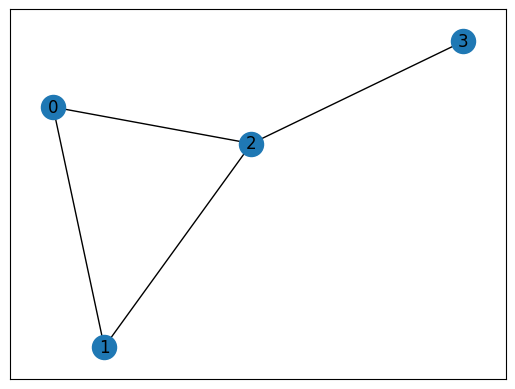

In [11]:
# Create the graph with networkx
G = nx.Graph()
G.add_nodes_from([2,1,0,3])

G.add_edge(0,1)
G.add_edge(1,2)
G.add_edge(2,0)
G.add_edge(2,3)

nx.draw_networkx(G, with_labels=True)

We choose the encoding type we want.

In [13]:
# Set the generator with the dual rail encoding
generator=StateGenerator(Encoding.DUAL_RAIL)

Then we use the generator to create the graph state:

In [15]:
gr_state = generator.graph_state(G)
print(gr_state)

-0.25*|1,0,1,0,0,1,0,1>+0.25*|0,1,1,0,1,0,1,0>+0.25*|1,0,1,0,1,0,0,1>+0.25*|1,0,1,0,1,0,1,0>+0.25*|0,1,1,0,0,1,0,1>-0.25*|0,1,0,1,0,1,1,0>+0.25*|1,0,0,1,1,0,1,0>+0.25*|1,0,0,1,1,0,0,1>-0.25*|0,1,0,1,1,0,1,0>+0.25*|0,1,1,0,1,0,0,1>-0.25*|0,1,1,0,0,1,1,0>+0.25*|1,0,0,1,0,1,0,1>+0.25*|0,1,0,1,0,1,0,1>+0.25*|1,0,1,0,0,1,1,0>-0.25*|1,0,0,1,0,1,1,0>-0.25*|0,1,0,1,1,0,0,1>


<br/>

## References

<a id="1">[1]</a>
Marc Hein et al. “Entanglement in graph states and its applications”. In: *arXiv preprint
quant-ph/0602096* (2006). https://arxiv.org/abs/quant-ph/0602096

<a id="2">[2]</a>
https://qiskit.org/documentation/stubs/qiskit.visualization.plot_state_qsphere.html

<a id="3">[3]</a>
https://nbviewer.org/urls/qutip.org/qutip-tutorials/tutorials-v4/visualization/qubism-and-schmidt-plots.ipynb


<a id="4">[4]</a>
https://perceval.quandela.net/interopdocs/

